In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [12]:
def get_policy(env, lr=0.001, hidden_layer_neurons = 128):
    output_shape = env.action_space.n
    input_shape = env.observation_space.shape
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    # model.compile(Adam(lr), loss=['categorical_crossentropy'])
    return model

In [13]:
# pip install box2d-py

In [14]:
# env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")
model = get_policy(env)

In [15]:
model.summary()
print(model.input)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 1,668
Trainable params: 1,668
Non-trainable params: 0
_________________________________________________________________
Tensor("dense_3_input:0", shape=(?, 8), dtype=float32)


In [16]:
obs

array([-0.00405912,  1.4045043 , -0.41114512, -0.2851513 ,  0.00471015,
        0.09313043,  0.        ,  0.        ], dtype=float32)

In [17]:
obs = env.reset()
actions_dist = model.predict_proba(obs.reshape(-1, env.observation_space.shape[0]))
sampled_action = np.random.choice(range(env.action_space.n), p=actions_dist[0])
print(obs, sampled_action)
obs, reward, done, _ = env.step(sampled_action)
print(obs)

[ 0.00173817  1.418797    0.17604367  0.3500894  -0.00200733 -0.03987651
  0.          0.        ] 1
[ 0.00338335  1.4261003   0.16414887  0.3245894  -0.00163969  0.00735424
  0.          0.        ]


In [21]:
def run_episode(env, model, seed=42, explore=True):
    done = False
    if seed>0:
        env.seed(seed)
    obs = env.reset()
    rewards = []
    observations = []
    actions = []
    while not done:
        actions_dist = model.predict_proba(obs.reshape(-1, env.observation_space.shape[0]))
        if explore:
            sampled_action = np.random.choice(range(env.action_space.n), p=actions_dist[0])
        else:
            sampled_action = np.argmax(actions_dist[0])
        obs_, reward, done, _ = env.step(sampled_action)
        rewards.append(reward)
        observations.append(obs)
        actions.append(sampled_action)
        obs = obs_
    return observations, actions, rewards

In [22]:
def monte_carlo(env, model, seed=42, N=1000, explore=True):
    returns = []
    for i in range(N):
        observations, actions, rewards = run_episode(env, model, seed=seed, explore=explore)
        returns.append(np.sum(rewards))
    returns = np.array(returns)
    estimated_V = np.cumsum(returns)/(np.array(range(len(returns)))+1)
    variance_V = (returns - estimated_V)**2
    variance_V = np.cumsum(variance_V)/(np.array(range(len(returns)))+1)
    return estimated_V, variance_V, returns

In [23]:
_, _, returns = monte_carlo(env, model, seed=42, N=20)

In [24]:
returns

array([-411.4274045 , -347.75032811, -243.56965033, -266.61386946,
       -414.88734953, -234.57784554, -222.80191452, -194.55278925,
       -453.06874637, -343.47440774, -248.28769646, -288.95209894,
       -428.21246862, -164.8498476 , -332.45185284, -453.06178011,
       -391.46036954, -316.7513789 , -356.61701497, -430.24886513])

In [33]:
N=200
estimated_V_1, variance_V_1, returns_1 = monte_carlo(env, model, N=N)
estimated_V_2, variance_V_2, returns_2 = monte_carlo(env, model, N=N)
estimated_V_3, variance_V_3, returns_3 = monte_carlo(env, model, N=N)

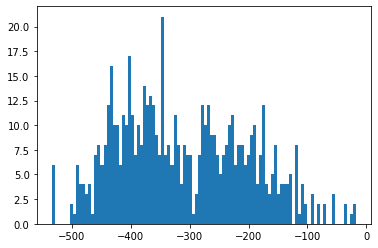

In [38]:
_ = plt.hist(np.hstack([returns_1, returns_2, returns_2]), 100)

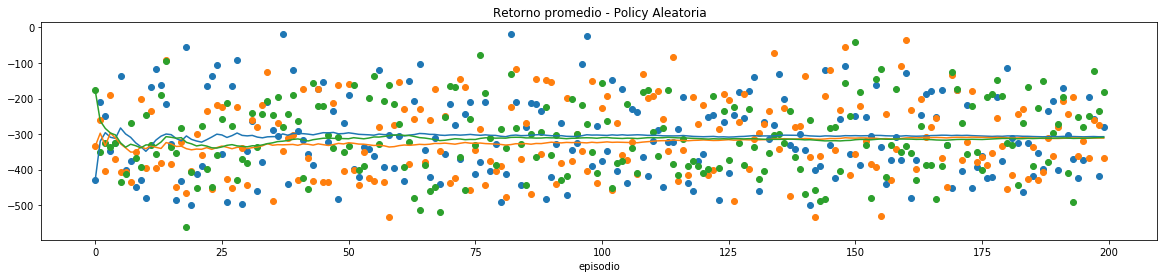

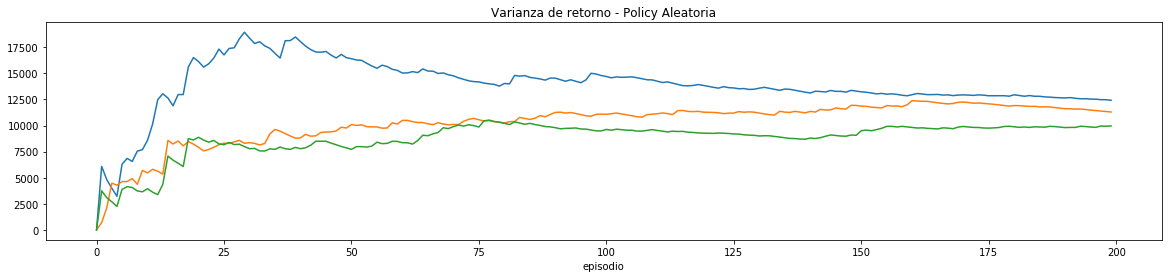

In [42]:
plt.figure(figsize=(20,4))
plt.plot(estimated_V_1[:N])
plt.plot(estimated_V_2[:N])
plt.plot(estimated_V_3[:N])
plt.scatter(range(len(returns_1)), returns_1)
plt.scatter(range(len(returns_2)), returns_2)
plt.scatter(range(len(returns_3)), returns_3)
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(variance_V_1[:N])
plt.plot(variance_V_2[:N])
plt.plot(variance_V_3[:N])
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()

In [52]:
estimated_V_1[-1], estimated_V_2[-1], estimated_V_3[-1]

(20.6966, 20.823, 20.7396)

In [53]:
variance_V_1[-1], variance_V_2[-1], variance_V_3[-1]

(117.16639522975103, 117.83592300616577, 117.79442567955509)

In [60]:
from keras.models import load_model
from keras import backend as K
def load_custom_model(filename):
    def loss_metric(y_true, y_pred):
        y_true_norm = K.sign(y_true)
        return K.categorical_crossentropy(y_true_norm, y_pred)
    return load_model(filename, custom_objects={'loss_metric': loss_metric})

In [63]:
model_trained = load_custom_model('1_1_0.999_0.001_1574261458.hdf5')

In [66]:
estimated_V_1_t, variance_V_1_t = monte_carlo(env, model_trained, N=100)
estimated_V_2_t, variance_V_2_t = monte_carlo(env, model_trained, N=100)
estimated_V_3_t, variance_V_3_t = monte_carlo(env, model_trained, N=100)

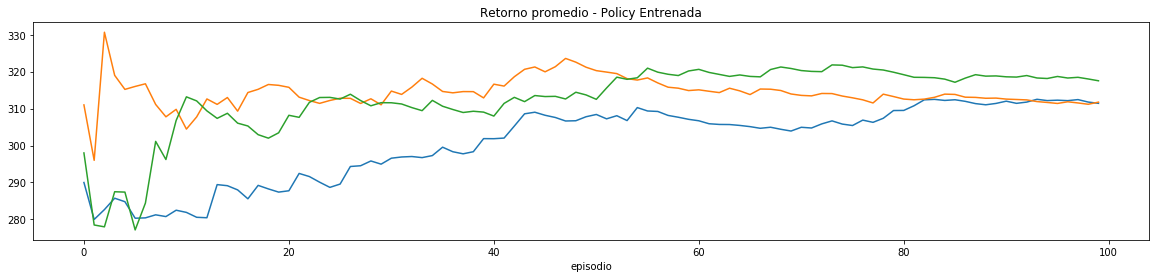

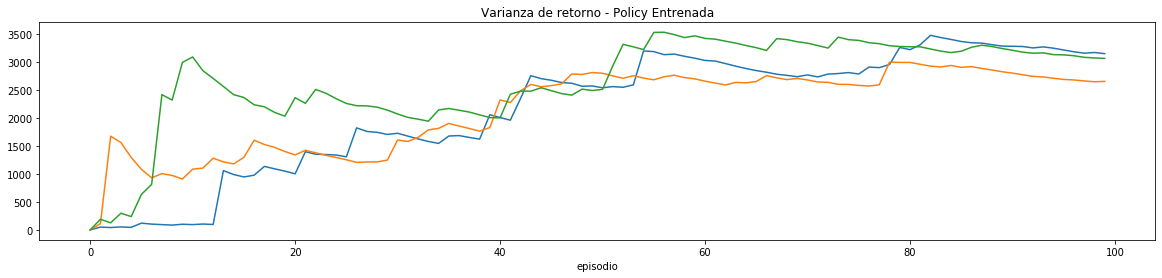

In [79]:
plt.figure(figsize=(20,4))
plt.plot(estimated_V_1_t)
plt.plot(estimated_V_2_t)
plt.plot(estimated_V_3_t)
plt.title('Retorno promedio - Policy Entrenada')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(variance_V_1_t)
plt.plot(variance_V_2_t)
plt.plot(variance_V_3_t)
plt.title('Varianza de retorno - Policy Entrenada')
plt.xlabel('episodio')
plt.show()

In [89]:
estimated_V_1_t_, variance_V_1_t_ = monte_carlo(env, model_trained, N=100, explore=False, seed=-1)
estimated_V_2_t_, variance_V_2_t_ = monte_carlo(env, model_trained, N=100, explore=False, seed=-1)
estimated_V_3_t_, variance_V_3_t_ = monte_carlo(env, model_trained, N=100, explore=False, seed=-1)

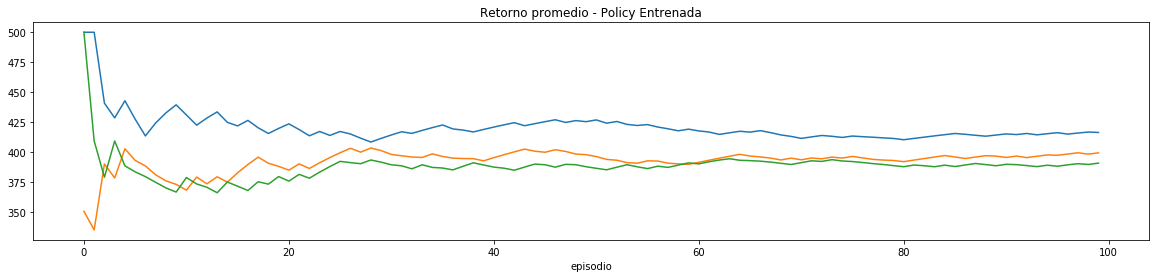

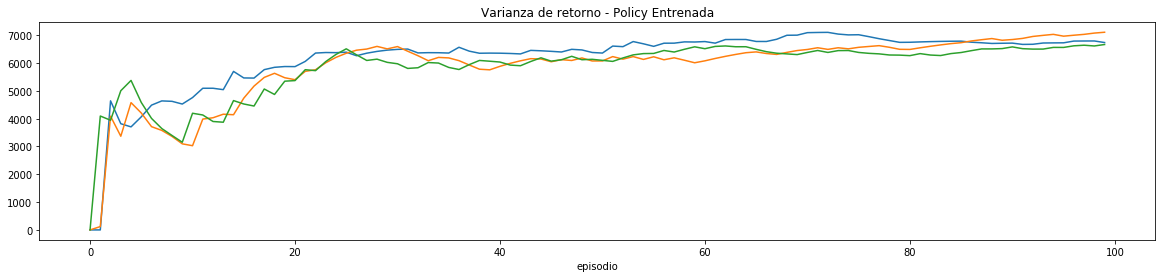

In [90]:
plt.figure(figsize=(20,4))
plt.plot(estimated_V_1_t_)
plt.plot(estimated_V_2_t_)
plt.plot(estimated_V_3_t_)
plt.title('Retorno promedio - Policy Entrenada')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(variance_V_1_t_)
plt.plot(variance_V_2_t_)
plt.plot(variance_V_3_t_)
plt.title('Varianza de retorno - Policy Entrenada')
plt.xlabel('episodio')
plt.show()